In [ ]:
pip install syft==0.2.9

     |████████████████████████████████| 440kB 4.3MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 20.1MB 50.4MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 2.0MB 41.1MB/s 
     |████████████████████████████████| 1.8MB 39.7MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 133kB 22.7MB/s 
     |████████████████████████████████| 450kB 43.7MB/s 
     |████████████████████████████████| 491kB 37.9MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 204kB 40.6MB/s 
     |████████████████████████████████| 9.0MB 25.9MB/s 
     |████████████████████████████████| 4.0MB 45.9MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 51kB 157kB/s 
     |

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import syft as sy
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# hook PyTorch to PySyft i.e. add extra functionalities to support Federated Learning
# and other private AI tools
hook = sy.TorchHook(torch)
 
# we create two imaginary schools
node1 = sy.VirtualWorker(hook, id="node1")
node2 = sy.VirtualWorker(hook, id="node2")


In [ ]:
df = pd.read_csv("bigdatamsme.csv")
df.head()

,Applied Loan Amount,Applied Loan Tenor,Loan Purpose,Gender,Age,Marital Status,Education Level,Residential Status,Monthly Housing/Rental,Contract Staff (Y/N),Employment Type,Nature of Business,Job Position,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators
0,200000,60,Personal use,M,59.482,Married,University,Mortgaged Private Housing,15182.0,N,Self-Employed,Owner of a Business,Self Employed,30000.0,0,0,1,0,0
1,100000,24,Personal use,M,49.745,Married,Secondary,Live With Relatives,0.0,N,Self-Employed,Owner of a Business,Self Employed,50000.0,1,0,0,0,0
2,286000,60,Personal use,F,55.584,Married,Secondary,Live With Relatives,0.0,N,Self-Employed,Owner of a Business,Self Employed,28600.0,0,0,1,0,0
3,190000,36,Personal use,F,56.677,Single,Post Secondary,Self-owned Private Housing,10000.0,N,Self-Employed,Owner of a Business,Self Employed,19800.0,1,0,0,0,0
4,50000,48,Settle Loan / Credit Card O/S,F,39.699,Married,Secondary,Self-owned Private Housing,0.0,N,Non Fixed Income Earner,Owner of a Business,Self Employed,13000.0,0,0,1,0,0


In [ ]:
df = df.dropna()
df = pd.get_dummies(df)
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head() 

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Investment,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,Residential Status_Mortgaged Private Housing,Residential Status_Mortgaged Public Housing,Residential Status_No Response,Residential Status_Rental,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_Owner of a Business,Job Position_Self Employed,Indicators
0,200000,60,59.482,15182.0,30000.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0
1,100000,24,49.745,0.0,50000.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,286000,60,55.584,0.0,28600.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
3,190000,36,56.677,10000.0,19800.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0
4,50000,48,39.699,0.0,13000.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0


In [ ]:
# df = df.astype(np.float64)
# df["Final_Status (Y/N)"].astype(int)
df.dtypes

Applied Loan Amount                                int64
Applied Loan Tenor                                 int64
Age                                              float64
Monthly Housing/Rental                           float64
Monthly Income                                   float64
Office (Area)_1                                    int64
Office (Area)_2                                    int64
Office (Area)_3                                    int64
Office (Area)_6                                    int64
Loan Purpose_Business                              uint8
Loan Purpose_Car Purchase                          uint8
Loan Purpose_Decoration                            uint8
Loan Purpose_Education                             uint8
Loan Purpose_Investment                            uint8
Loan Purpose_Personal use                          uint8
Loan Purpose_Settle Loan / Credit Card O/S         uint8
Loan Purpose_Stand by                              uint8
Loan Purpose_Tax Payment       

In [ ]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

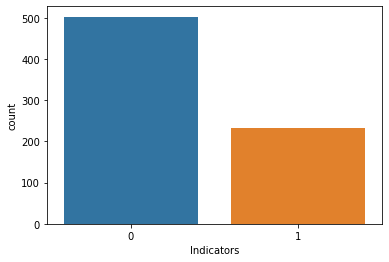

In [ ]:
sns.countplot(x = 'Indicators', data=df)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
print(X.shape, y.shape)

(736, 48) (736,)


In [ ]:
np.any(np.isnan(y))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

167

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(493, 48) (243, 48)


In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(torch.Tensor(y_train.values)))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = sy.FederatedDataLoader(train_data.federate((node1, node2)), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) # may need increase later

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(48, 160)
        self.layer_2 = nn.Linear(160, 40)
        self.layer_out = nn.Linear(40, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(160)
        self.batchnorm2 = nn.BatchNorm1d(40)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
# check to use GPU or not
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
###############

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=48, out_features=160, bias=True)
  (layer_2): Linear(in_features=160, out_features=40, bias=True)
  (layer_out): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
e_loss = []
e_acc = []
timelist = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        model = model.send(X_batch.location)

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        model.get()

        epoch_loss += loss.get()
        epoch_acc += acc.get()
    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append((epoch_loss/len(train_loader)).item()) # for plt
    e_acc.append((epoch_acc/len(train_loader)).item()) # for plt
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Time: {total_time:.3f}')

Epoch 001: | Loss: 0.74387 | Acc: 47.250 | Time: 1.053
Epoch 002: | Loss: 0.73407 | Acc: 47.750 | Time: 0.976
Epoch 003: | Loss: 0.72859 | Acc: 49.000 | Time: 0.991
Epoch 004: | Loss: 0.73591 | Acc: 48.500 | Time: 0.957
Epoch 005: | Loss: 0.72057 | Acc: 46.750 | Time: 0.970
Epoch 006: | Loss: 0.71719 | Acc: 49.000 | Time: 0.966
Epoch 007: | Loss: 0.70129 | Acc: 52.250 | Time: 0.941
Epoch 008: | Loss: 0.70758 | Acc: 52.625 | Time: 0.917
Epoch 009: | Loss: 0.69798 | Acc: 54.000 | Time: 0.912
Epoch 010: | Loss: 0.69215 | Acc: 55.125 | Time: 0.957
Epoch 011: | Loss: 0.69260 | Acc: 57.750 | Time: 0.945
Epoch 012: | Loss: 0.67837 | Acc: 55.750 | Time: 0.919
Epoch 013: | Loss: 0.67296 | Acc: 59.875 | Time: 0.930
Epoch 014: | Loss: 0.66889 | Acc: 56.500 | Time: 0.969
Epoch 015: | Loss: 0.67081 | Acc: 59.875 | Time: 0.938
Epoch 016: | Loss: 0.66036 | Acc: 61.125 | Time: 0.940
Epoch 017: | Loss: 0.66835 | Acc: 59.125 | Time: 0.912
Epoch 018: | Loss: 0.65272 | Acc: 63.625 | Time: 0.912
Epoch 019:

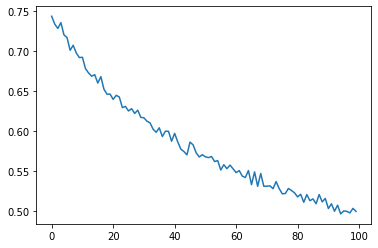

In [ ]:
plt.plot(e_loss)

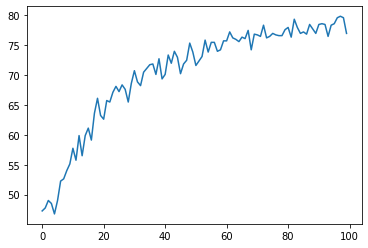

In [ ]:
plt.plot(e_acc)

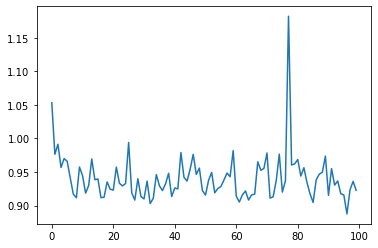

In [ ]:
plt.plot(timelist)

In [ ]:

import statistics
statistics.mean(timelist)

0.9403933930397034

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[124,  43],
       [ 22,  54]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       167
           1       0.56      0.71      0.62        76

    accuracy                           0.73       243
   macro avg       0.70      0.73      0.71       243
weighted avg       0.76      0.73      0.74       243

